In [8]:
import pandas as pd
import numpy as np

In [9]:
path = 'aki_patients.csv'
df = pd.read_csv(path)
# df = df.head(10000)
df['charttime'] = pd.to_datetime(df['charttime'])

In [10]:
# Function that filters ICU stays with +2  AKI stages and >1 day between the first and the day of max AKI stage
def cut_groups(df):
    res = pd.DataFrame()
    rows = []
    i = 0
    j = 0

    for group in df.groupby('stay_id'):
        group = group[1].sort_values(by='charttime')
        
        max_index = group['aki_stage'].idxmax()
        if(
            group['aki_stage'].max() - group['aki_stage'].iloc[0] >= 2 and
            group.loc[max_index]['charttime'] - group['charttime'].iloc[0] >= pd.Timedelta(days=1)
        ):
            # Add label
            group['worsened'] = 1

            # Crop group to the first day of max AKI stage (NOT including the day of max AKI stage)
            group = group[group['charttime'] < group.loc[max_index]['charttime']]
            
            res = pd.concat([res, group])
            i += 1
            rows.append(len(group))
        elif (
                group['aki_stage'].max() == 0 and
                group['charttime'].iloc[-1] - group['charttime'].iloc[0] >= pd.Timedelta(days=3.8) # days=3.8 was determined through T+E to balance + and - sets
        ):
            # Add label
            group['worsened'] = 0
            res = pd.concat([res, group])
            j += 1
            rows.append(len(group))
    return res, rows, i, j

In [11]:
df, rows, i, j = cut_groups(df)
print(df.isnull().sum())
print(i)
print(j)
# print(pd.Series(rows).describe())
df

subject_id             0
stay_id                0
charttime              0
valuenum               0
warning                0
baseline_creatinine    0
aki_stage              0
worsened               0
dtype: int64
2694
2733


,subject_id,stay_id,charttime,valuenum,warning,baseline_creatinine,aki_stage,worsened
28052,10682002,30003087,2132-12-02 04:29:00,0.7,0.0,0.6,0,0
28053,10682002,30003087,2132-12-03 02:20:00,0.7,0.0,0.6,0,0
28054,10682002,30003087,2132-12-04 03:20:00,0.7,0.0,0.6,0,0
28055,10682002,30003087,2132-12-05 03:35:00,0.6,0.0,0.6,0,0
28056,10682002,30003087,2132-12-06 04:43:00,0.7,0.0,0.6,0,0
...,...,...,...,...,...,...,...,...
105326,12478391,39996867,2165-06-22 03:02:00,0.6,0.0,0.4,0,0
105327,12478391,39996867,2165-06-22 16:19:00,0.6,0.0,0.4,0,0
105328,12478391,39996867,2165-06-23 04:17:00,0.5,0.0,0.4,0,0
105329,12478391,39996867,2165-06-23 17:45:00,0.6,0.0,0.4,0,0


count    5427.000000
mean        4.978909
std         4.479529
min         0.000000
25%         2.030903
50%         4.404167
75%         6.264931
max       165.672222
dtype: float64


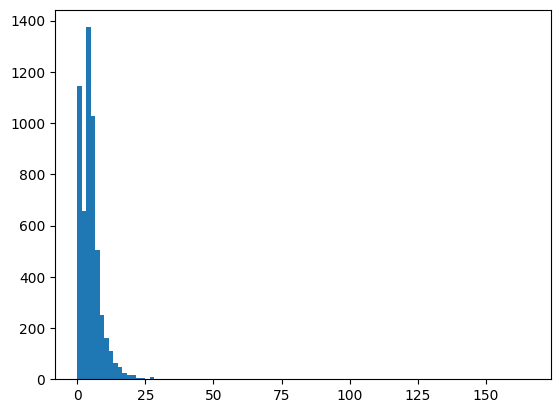

In [12]:
res = []
for group in df.groupby('stay_id'):
    time_of_stay = group[1]['charttime'].iloc[-1] - group[1]['charttime'].iloc[0]
    res.append(time_of_stay.total_seconds() / 60 / 60 / 24)
print(pd.Series(res).describe())
# graph
import matplotlib.pyplot as plt
plt.hist(res, bins=100)
plt.show()

In [13]:
df.reset_index(drop=True, inplace=True)
df.to_csv('aki_patients_filtered.csv', index=False)